In [1]:
# Import Required Libraries

import pandas as pd
import math
import numpy as np

import matplotlib.pyplot as plt

import plotly.graph_objs as go
from plotly.offline import iplot

from prophet import Prophet
import holidays
from prophet.diagnostics import cross_validation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

C:\Users\Arcega\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [2]:
# Import dataset
df = pd.read_csv('data/00_MRT_2023_Prophet_weather2.csv', parse_dates=[0])
df.head

<bound method NDFrame.head of                  Datetime  Entry  is_weekend  rain_amount
0     2022-01-01 04:00:00      0           1          0.0
1     2022-01-01 05:00:00      0           1          0.0
2     2022-01-01 06:00:00    525           1          0.0
3     2022-01-01 07:00:00    610           1          0.0
4     2022-01-01 08:00:00    684           1          0.0
...                   ...    ...         ...          ...
14595 2023-12-31 19:00:00   1681           1          0.0
14596 2023-12-31 20:00:00    297           1          0.0
14597 2023-12-31 21:00:00      0           1          0.0
14598 2023-12-31 22:00:00      0           1          0.0
14599 2023-12-31 23:00:00      0           1          0.0

[14600 rows x 4 columns]>

In [3]:
def is_weekend(ds):
    date = pd.to_datetime(ds)
    # Return True for Saturday (5) and Sunday (6), False otherwise
    return date.weekday() >= 5

In [4]:
# Rename header to Prophet's requirements
df.reset_index()
df = df.rename(columns={'Datetime':'ds', 'Entry':'y'})

# Add additional regressors as columns in the dataframe
df['hour'] = pd.to_datetime(df['ds']).dt.hour
df['rush_hour'] = df['ds'].apply(lambda x: 1 if (x.weekday() < 5 and x.hour == 7) else 0)
df['weekend_rush_hour'] = df['ds'].apply(lambda x: 1 if (x.weekday() >= 5 and x.hour == 7) else 0)
df['off_hour'] = df['hour'].apply(lambda x: 1 if (x >= 23) or (x <= 3) else 0)
df['weekday'] = ~df['ds'].apply(is_weekend)
df['weekend'] = df['ds'].apply(is_weekend)
df.tail(100)

,ds,y,is_weekend,rain_amount,hour,rush_hour,weekend_rush_hour,off_hour,weekday,weekend
14500,2023-12-27 04:00:00,0,0,5.5,4,0,0,0,True,False
14501,2023-12-27 05:00:00,2627,0,5.5,5,0,0,0,True,False
14502,2023-12-27 06:00:00,3429,0,5.5,6,0,0,0,True,False
14503,2023-12-27 07:00:00,4714,0,5.5,7,1,0,0,True,False
14504,2023-12-27 08:00:00,4283,0,5.5,8,0,0,0,True,False
...,...,...,...,...,...,...,...,...,...,...
14595,2023-12-31 19:00:00,1681,1,0.0,19,0,0,0,False,True
14596,2023-12-31 20:00:00,297,1,0.0,20,0,0,0,False,True
14597,2023-12-31 21:00:00,0,1,0.0,21,0,0,0,False,True
14598,2023-12-31 22:00:00,0,1,0.0,22,0,0,0,False,True


In [5]:
# Split the dataset to training and testing sets
train_len = math.floor((df.shape[0]*80)/100)
train = df[:train_len]
test = df[train_len:]

train.head()
test.head()

,ds,y,is_weekend,rain_amount,hour,rush_hour,weekend_rush_hour,off_hour,weekday,weekend
11680,2023-08-08 04:00:00,0,0,3.5,4,0,0,0,True,False
11681,2023-08-08 05:00:00,2941,0,3.5,5,0,0,0,True,False
11682,2023-08-08 06:00:00,4881,0,3.5,6,0,0,0,True,False
11683,2023-08-08 07:00:00,5821,0,3.5,7,1,0,0,True,False
11684,2023-08-08 08:00:00,4879,0,3.5,8,0,0,0,True,False


In [6]:
# Visualize the test train split
train_samples = go.Scatter(x = train['ds'],
                  y = train['y'],
                  mode = 'lines',
                  name = 'Train')

test_samples = go.Scatter(x = test['ds'],
                  y = test['y'],
                  mode = 'lines',
                  name = 'Test')

layout = go.Layout(title={'text': 'Train/test split',
                          'y':0.9,
                          'x':0.5,
                          'xanchor': 'center',
                          'yanchor': 'top'},
                   xaxis = dict(title = 'Year'),
                   yaxis = dict(title = 'Entry'),
                   template = 'plotly_dark')

data = [train_samples, test_samples]
fig = go.Figure(data = data, layout = layout)
iplot(fig)

In [7]:
# Create holidays dataframe
holiday = pd.DataFrame([])
for date, name in sorted(holidays.Philippines(years=[2022, 2023]).items()):
    holiday = pd.concat([holiday, pd.DataFrame({'ds': date, 'holiday': name}, index=[0])], ignore_index=True)
holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

holiday.head(10)


,ds,holiday
0,2022-01-01,New Year's Day
1,2022-02-01,Chinese New Year
2,2022-02-25,EDSA Revolution Anniversary
3,2022-04-09,Day of Valor
4,2022-04-14,Maundy Thursday
5,2022-04-15,Good Friday
6,2022-04-16,Black Saturday
7,2022-05-01,Labour Day
8,2022-05-02,Eid'l Fitr (estimated)
9,2022-06-12,Independence Day


In [8]:
# Initialize the Prophet model
m = Prophet(
    yearly_seasonality=True,
    daily_seasonality=False,
    weekly_seasonality=True,
    holidays=holiday,
    seasonality_mode='multiplicative',
    scaling='minmax'
)

# Add the regressors
m.add_seasonality(name='daily_is_weekend', period=1, fourier_order=4, condition_name='weekend')
m.add_seasonality(name='daily_is_weekday', period=1, fourier_order=4, condition_name='weekday')
#m.add_regressor('rush_hour')
m.add_regressor('off_hour')
#m.add_regressor('weekend_rush_hour')
m.add_regressor('rain_amount')

# Fit the model on the training data
m.fit(train)

12:12:25 - cmdstanpy - INFO - Chain [1] start processing
12:12:45 - cmdstanpy - INFO - Chain [1] done processing


In [9]:
test_forecast = m.predict(test)
#test_forecast['yhat'] = test_forecast['yhat'].apply(lambda x: max(x, 0))
#test_forecast['yhat_lower'] = test_forecast['yhat_lower'].apply(lambda x: max(x, 0))
#test_forecast['yhat_upper'] = test_forecast['yhat_upper'].apply(lambda x: max(x, 0))
#test_forecast['yhat'] = test_forecast['yhat'].round()

test_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2023-08-08 04:00:00,-64.430071,-644.518374,511.790841
1,2023-08-08 05:00:00,2736.173300,2133.433384,3373.251733
2,2023-08-08 06:00:00,4447.940654,3865.422472,5026.813117
3,2023-08-08 07:00:00,4818.495881,4213.841215,5425.913329
4,2023-08-08 08:00:00,4298.001118,3679.631525,4914.162486


In [10]:
# Create a future DataFrame with hourly intervals for the desired forecast period
future = m.make_future_dataframe(periods=150, freq='D')
future['hour'] = pd.to_datetime(future['ds']).dt.hour
future['is_weekend'] = df['is_weekend']
future['weekday'] = future['ds'].apply(is_weekend)
future['weekend'] = ~future['ds'].apply(is_weekend)
future['rain_amount'] = df['rain_amount']
#future['rush_hour'] = future['hour'].apply(lambda x: 1 if (7 == x) else 0)
#future['weekend_rush_hour'] = future['ds'].apply(lambda x: 1 if (x.weekday() >= 5 and x.hour == 7) else 0)
future['off_hour'] = future['hour'].apply(lambda x: 1 if (x >= 23) or (x <= 3) else 0)
future = future[future['ds'].dt.hour < 23]
future = future[future['ds'].dt.hour > 3]


# Make predictions
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2022-01-01 04:00:00,-172.501401,-739.042627,422.846161
1,2022-01-01 05:00:00,777.059850,201.180725,1367.936425
2,2022-01-01 06:00:00,1356.522595,810.316244,1893.080063
3,2022-01-01 07:00:00,1480.717780,941.101893,2035.095091
4,2022-01-01 08:00:00,1302.629551,707.110834,1943.091487


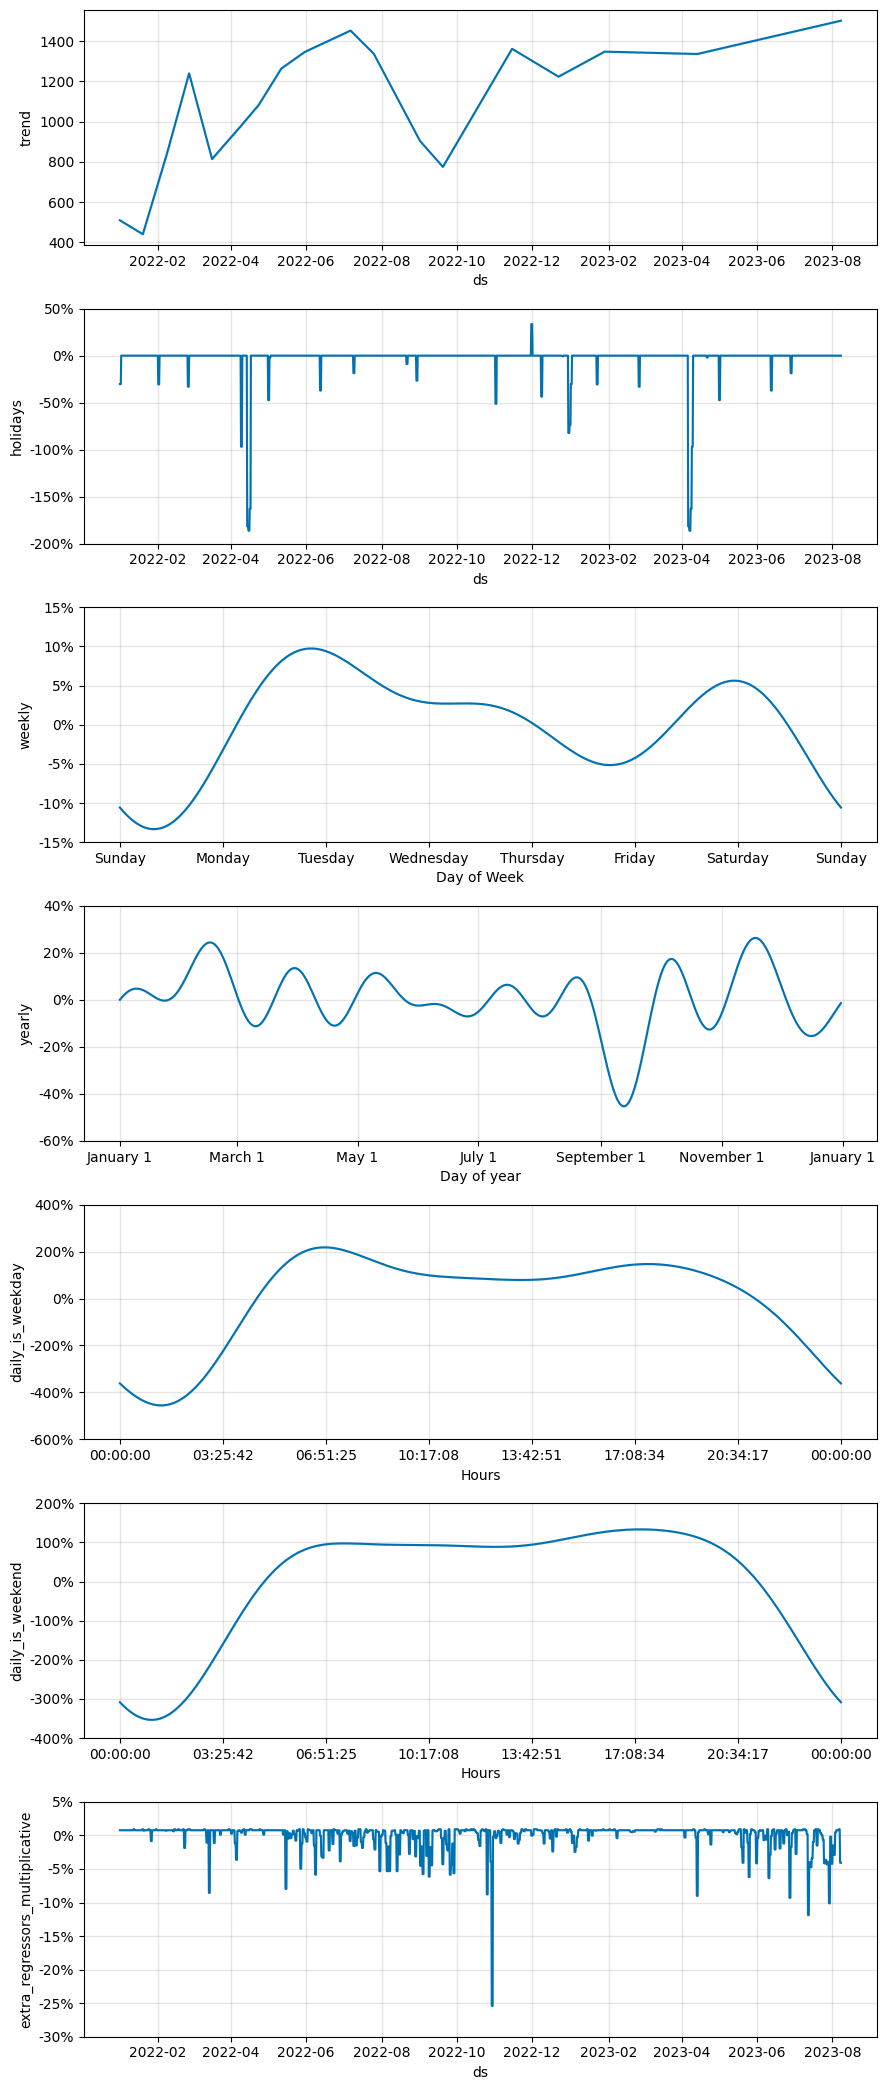

In [11]:
fig = m.plot_components(forecast)

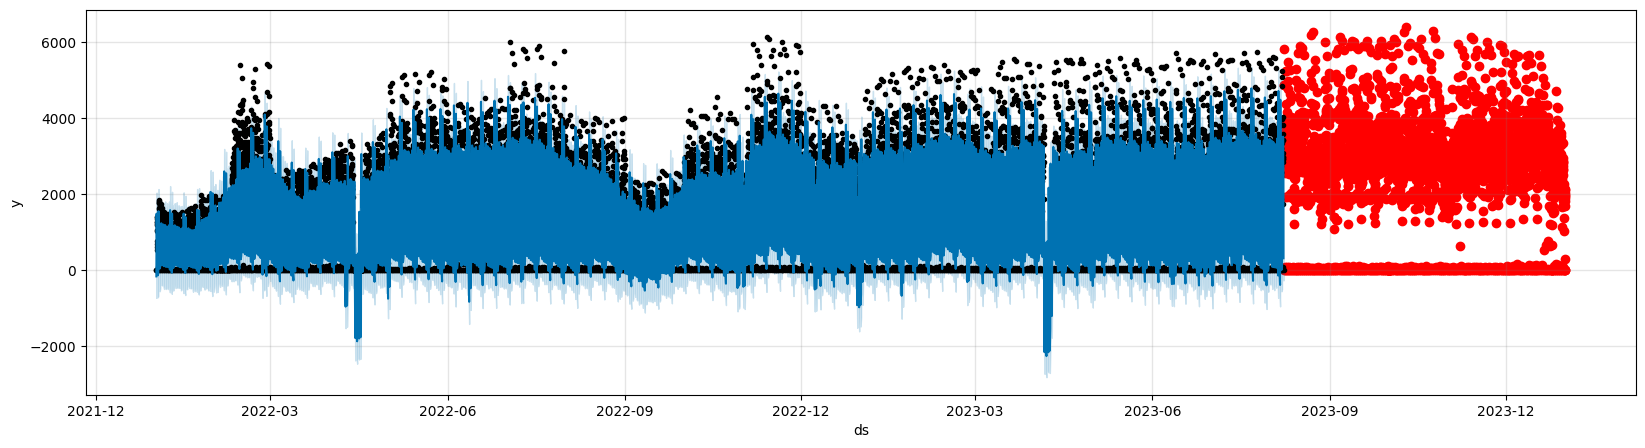

In [12]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(20)
ax.scatter(test.ds, test['y'], color='r')
fig = m.plot(forecast,ax=ax)
plt.show()

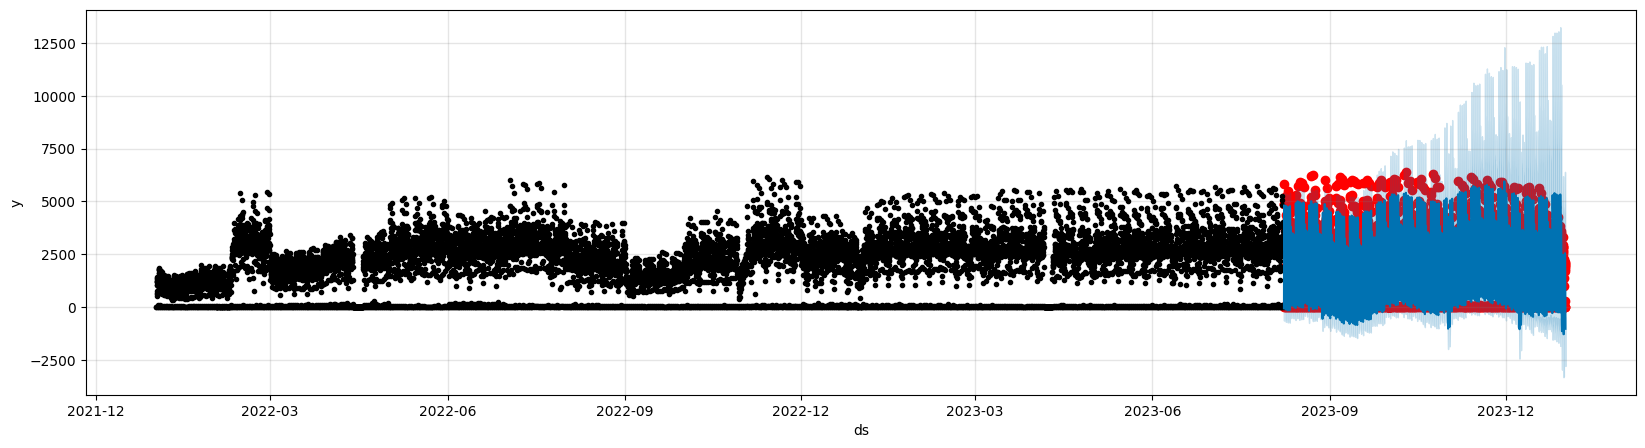

In [13]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(20)
ax.scatter(test.ds, test['y'], color='r')
fig = m.plot(test_forecast, ax=ax)

In [14]:
train_samples = go.Scatter(x = test_forecast['ds'],
                  y = test_forecast['yhat'],
                  mode = 'lines',
                  name = 'Train')
test_samples = go.Scatter(x = test['ds'],
                  y = test['y'],
                  mode = 'lines',
                  name = 'Test')

layout = go.Layout(title={'text': 'Actuals vs Forecast',
                          'y':0.9,
                          'x':0.5,
                          'xanchor': 'center',
                          'yanchor': 'top'},
                   xaxis = dict(title = 'Year'),
                   yaxis = dict(title = 'Entry'),
                   template = 'plotly_dark')

data = [train_samples, test_samples]
fig = go.Figure(data = data, layout = layout)
iplot(fig)

In [15]:
train_samples = go.Scatter(x = forecast['ds'],
                  y = forecast['yhat'],
                  mode = 'lines',
                  name = 'Train')
test_samples = go.Scatter(x = df['ds'],
                  y = df['y'],
                  mode = 'lines',
                  name = 'Actual')

layout = go.Layout(title={'text': 'Actuals vs Forecast',
                          'y':0.9,
                          'x':0.5,
                          'xanchor': 'center',
                          'yanchor': 'top'},
                   xaxis = dict(title = 'Year'),
                   yaxis = dict(title = 'Entry'),
                   template = 'plotly_dark')

data = [train_samples, test_samples]
fig = go.Figure(data = data, layout = layout)
iplot(fig)

In [16]:
mse = mean_squared_error(y_true=test['y'],  y_pred=test_forecast['yhat'])
rmse = np.sqrt(mean_squared_error(y_true=test['y'], y_pred=test_forecast['yhat']))
mae = mean_absolute_error(y_true=test['y'], y_pred=test_forecast['yhat'])
r2 = r2_score(y_true=test['y'], y_pred=test_forecast['yhat'])
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R^2 Score: {r2}')

MSE: 403863.24218089477
RMSE: 635.5023541898919
MAE: 447.40894713254016
R^2 Score: 0.7950788642695374


In [ ]:
#horizon 7
df_cv = cross_validation(m, initial = '400 days', horizon='7 days')

df_cv.head()


  0%|          | 0/51 [00:00<?, ?it/s]12:12:55 - cmdstanpy - INFO - Chain [1] start processing


In [61]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mdape,smape,coverage
0,0 days 18:00:00,155358.921322,394.155961,280.734657,0.092230,0.362599,0.903361
1,0 days 19:00:00,156401.887093,395.476785,282.395897,0.094577,0.359533,0.903361
2,0 days 20:00:00,158399.559381,397.994421,284.622507,0.094443,0.354036,0.899324
3,0 days 21:00:00,161719.843433,402.144058,288.863346,0.089495,0.288251,0.899544
4,0 days 22:00:00,153968.739931,392.388506,280.354165,0.090392,0.287435,0.906657


In [62]:
comparison = df_p.mean()[1:]
print(comparison)

mse         265867.167849
rmse           505.137419
mae            353.475355
mdape            0.126355
smape            0.416227
coverage         0.833828
dtype: object


In [58]:
#horizon 30
df_cv2 = cross_validation(m, initial = '400 days', horizon='30 days')

df_cv2.head()


  0%|          | 0/11 [00:00<?, ?it/s]00:52:55 - cmdstanpy - INFO - Chain [1] start processing
00:53:03 - cmdstanpy - INFO - Chain [1] done processing
  9%|▉         | 1/11 [00:10<01:41, 10.17s/it]00:53:05 - cmdstanpy - INFO - Chain [1] start processing
00:53:18 - cmdstanpy - INFO - Chain [1] done processing
 18%|█▊        | 2/11 [00:25<01:57, 13.03s/it]00:53:20 - cmdstanpy - INFO - Chain [1] start processing
00:53:31 - cmdstanpy - INFO - Chain [1] done processing
 27%|██▋       | 3/11 [00:38<01:45, 13.19s/it]00:53:33 - cmdstanpy - INFO - Chain [1] start processing
00:53:47 - cmdstanpy - INFO - Chain [1] done processing
 36%|███▋      | 4/11 [00:54<01:40, 14.33s/it]00:53:50 - cmdstanpy - INFO - Chain [1] start processing
00:54:02 - cmdstanpy - INFO - Chain [1] done processing
 45%|████▌     | 5/11 [01:08<01:25, 14.29s/it]00:54:03 - cmdstanpy - INFO - Chain [1] start processing
00:54:17 - cmdstanpy - INFO - Chain [1] done processing
 55%|█████▍    | 6/11 [01:24<01:13, 14.75s/it]00:54:19

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2023-02-09 04:00:00,226.698272,-318.652895,821.718786,0,2023-02-08 23:00:00
1,2023-02-09 05:00:00,2598.164855,2015.003129,3185.546539,2566,2023-02-08 23:00:00
2,2023-02-09 06:00:00,4037.096278,3485.810009,4632.533414,4117,2023-02-08 23:00:00
3,2023-02-09 07:00:00,4367.976474,3817.189867,4940.926745,4977,2023-02-08 23:00:00
4,2023-02-09 08:00:00,3985.751518,3424.361782,4577.037834,4116,2023-02-08 23:00:00


In [59]:
from prophet.diagnostics import performance_metrics
df_p2 = performance_metrics(df_cv2)
df_p2.head()

,horizon,mse,rmse,mae,mdape,smape,coverage
0,3 days 00:00:00,198652.221682,445.704186,332.203236,0.122663,0.376567,0.833333
1,3 days 05:00:00,199915.205607,447.118782,333.794239,0.122663,0.376567,0.831818
2,3 days 06:00:00,202777.837383,450.308602,336.364044,0.123202,0.377572,0.827273
3,3 days 07:00:00,207324.552719,455.329060,338.042120,0.123202,0.377962,0.824242
4,3 days 08:00:00,210794.045759,459.123127,340.853493,0.124289,0.378387,0.822727


In [60]:
comparison2 = df_p2.mean()[1:]
print(comparison2)

mse         292672.470372
rmse            533.42763
mae            381.148916
mdape            0.133927
smape            0.419756
coverage         0.831944
dtype: object


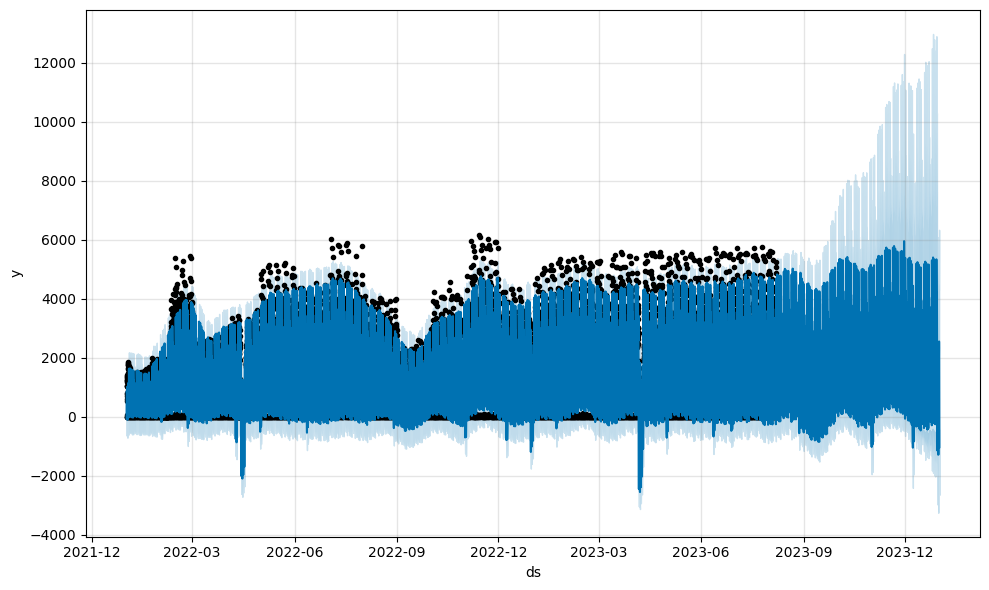

In [63]:
m.plot(m.predict(df));

In [264]:
# Python
import itertools
import numpy as np
import pandas as pd

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(df)  # Fit model with given params
    df_cv = cross_validation(m, horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

14:02:40 - cmdstanpy - INFO - Chain [1] start processing
14:02:42 - cmdstanpy - INFO - Chain [1] done processing
14:03:20 - cmdstanpy - INFO - Chain [1] start processing
14:03:22 - cmdstanpy - INFO - Chain [1] done processing
14:03:58 - cmdstanpy - INFO - Chain [1] start processing
14:04:01 - cmdstanpy - INFO - Chain [1] done processing
14:04:37 - cmdstanpy - INFO - Chain [1] start processing
14:04:38 - cmdstanpy - INFO - Chain [1] done processing
14:05:11 - cmdstanpy - INFO - Chain [1] start processing
14:05:15 - cmdstanpy - INFO - Chain [1] done processing
14:06:32 - cmdstanpy - INFO - Chain [1] start processing
14:06:35 - cmdstanpy - INFO - Chain [1] done processing
14:07:56 - cmdstanpy - INFO - Chain [1] start processing
14:07:59 - cmdstanpy - INFO - Chain [1] done processing
14:09:16 - cmdstanpy - INFO - Chain [1] start processing
14:09:19 - cmdstanpy - INFO - Chain [1] done processing
14:10:46 - cmdstanpy - INFO - Chain [1] start processing
14:10:59 - cmdstanpy - INFO - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale        rmse
0                     0.001                     0.01  803.389526
1                     0.001                     0.10  774.663927
2                     0.001                     1.00  775.794401
3                     0.001                    10.00  774.677982
4                     0.010                     0.01  831.133328
5                     0.010                     0.10  804.748719
6                     0.010                     1.00  804.515438
7                     0.010                    10.00  807.698170
8                     0.100                     0.01  854.391161
9                     0.100                     0.10  837.113361
10                    0.100                     1.00  835.466094
11                    0.100                    10.00  837.623965
12                    0.500                     0.01  870.910560
13                    0.500                     0.10  853.056008
14                    0.5

In [267]:
# Get best combination o hypertuning parameters
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1}


In [268]:
from prophet.utilities import regressor_coefficients
regressor_coefficients(m)

AssertionError: No extra regressors found.

In [78]:
print(df_p)

            horizon            mse        rmse         mae     mdape  \
0   0 days 16:00:00  245929.428751  495.912723  328.430721  0.108578   
1   0 days 17:00:00  219326.797784  468.323390  301.979667  0.109918   
2   0 days 18:00:00  225230.403027  474.584453  297.675491  0.108375   
3   0 days 19:00:00  231605.546742  481.254139  293.613349  0.105714   
4   0 days 20:00:00  244229.482336  494.195794  296.752416  0.108262   
..              ...            ...         ...         ...       ...   
148 6 days 20:00:00  102008.777237  319.388129  247.559577  0.094328   
149 6 days 21:00:00  100385.456462  316.836640  245.702399  0.092973   
150 6 days 22:00:00  102464.317929  320.100481  249.128744  0.095085   
151 6 days 23:00:00  108331.851218  329.138043  257.871293  0.091728   
152 7 days 00:00:00  123399.745830  351.283000  264.881316  0.089077   

        smape  coverage  
0    0.349544  0.838938  
1    0.418632  0.871338  
2    0.419624  0.875768  
3    0.420631  0.880004  
4    